In [1]:
!pip install tensorflow

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - accuracy: 0.6134 - loss: 1.1397 - val_accuracy: 0.7694 - val_loss: 0.6742 - learning_rate: 0.0010
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7389 - loss: 0.7588 - val_accuracy: 0.7782 - val_loss: 0.6495 - learning_rate: 0.0010
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7529 - loss: 0.7023 - val_accuracy: 0.7710 - val_loss: 0.6521 - learning_rate: 0.0010
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7668 - loss: 0.6730 - val_accuracy: 0.7820 - val_loss: 0.6200 - learning_rate: 0.0010
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7767 - loss: 0.6406 - val_accuracy: 0.7905 - val_loss: 0.6154 - learning_rate: 0.0010
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7815 - loss: 0.6162 - val_accuracy: 0.7977 - val_loss: 0.6027 - learning_rate: 0.0010
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accura

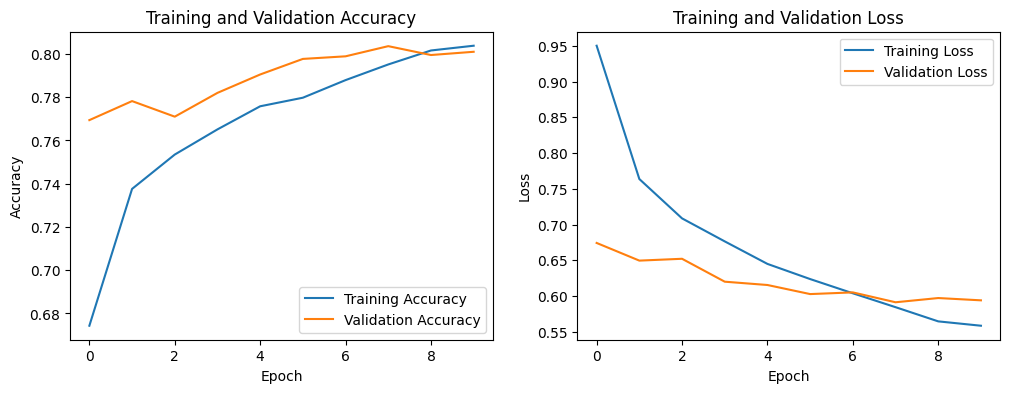

In [ ]:
# Step 1: Import Libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks, applications
import matplotlib.pyplot as plt
import numpy as np

# Step 2: Load and Preprocess CIFAR-10 Dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to range [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define class names for visualization
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Step 3: Create the Model - Transfer Learning
# Load the pre-trained MobileNetV2 model without the top classification layer
# weights='imagenet' -> Use weights pre-trained on ImageNet
# input_shape -> The dimensions of our images
# include_top=False -> We will define our own classification layer
base_model = applications.MobileNetV2(
    input_shape=(96, 96, 3), # Corrected input shape to match the upsampled image
    include_top=False,
    weights='imagenet'
)

# Freeze the weights of the pre-trained model
base_model.trainable = False

# Create our own model
# We need to upscale the 32x32 images because MobileNetV2 performs better on larger images
# Here we upscale them to 96x96
inputs = layers.Input(shape=(32, 32, 3))
x = layers.UpSampling2D(size=(3,3))(inputs) # Upscale the image
x = base_model(x, training=False) # Ensure base_model is in inference mode
x = layers.GlobalAveragePooling2D()(x) # Convert feature map to a vector
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x) # Add Dropout to prevent overfitting
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Display the model summary
model.summary()


# Step 4: Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Step 5: Define Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, # Increased patience since there's only one training phase
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Reduce learning rate by a factor of 0.2 when it plateaus
    patience=3,
    min_lr=0.00001 # Minimum learning rate
)

# Step 6: Train the Model
history = model.fit(train_images, train_labels,
                    epochs=12, # Train for more epochs as there is no fine-tuning stage
                    validation_data=(test_images, test_labels),
                    callbacks=[early_stopping, reduce_lr])


# Step 7: Evaluate, Visualize, and Print Summary
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

# Extract final metrics from the history object
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
total_epochs = len(history.history['accuracy'])

# Print the final performance summary
print("\nModel Performance Summary:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Training Epochs: {total_epochs}")


# Plotting the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()